# Testing prompts for Classifying emails

## Importing libraries

In [7]:
import os
import requests
from dotenv import load_dotenv
from langsmith import traceable
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import re

import warnings
warnings.filterwarnings("ignore")

### Getting Path of current file
import os
import sys
from pathlib import Path

path = Path(os.path.dirname(os.getcwd()))
path = str(path)
print(path)
sys.path.insert(1, path)

/Users/saideepbunny/Projects/Email-Assistant-using-Generative-AI


## Setting API keys

In [8]:
load_dotenv(dotenv_path=f"{path}/config/nvidia_token.env")

model1 = "google/gemma-3n-e4b-it"
model2 = "mistralai/mistral-nemotron"
model3 = "meta/llama-4-maverick-17b-128e-instruct"

token1 = os.getenv("GEMMA_API_KEY")
token2 = os.getenv("MISTRAL_API_KEY")
token3 = os.getenv("LLAMA_API_KEY")

## Classification function

In [9]:
def classify_email(model, token, prompt_msg, email_content: str, examples: list = None):
    """
    Classify emails using an NVIDIA LLM with optional few-shot examples.

    Args:
        model (str): NVIDIA LLM model name.
        token (str): API key for NVIDIA LLM.
        prompt_msg (str): Classification instruction message.
        email_content (str): Email text to classify.
        examples (list, optional): Few-shot examples in the form 
                                   [{"email": "example email", "label": "JOB"}, ...]

    Returns:
        str: Cleaned classification result (only capital letters).
    """

    # Build few-shot messages
    messages = []

    # Add few-shot examples if provided
    if examples:
        for ex in examples:
            messages.append(("user", ex["email"]))
            messages.append(("assistant", ex["label"]))

    # Add the actual email to classify
    messages.append((
        "user",
        f"""{{email_content}}\n\n{prompt_msg}"""
    ))

    # Create prompt template
    prompt = ChatPromptTemplate.from_messages(messages)

    # Use the NVIDIA LLM via LangChain
    llm = ChatNVIDIA(
        model=model,
        api_key=token,
        temperature=0.2,
        max_tokens=4096,
        streaming=False
    )

    # Define chain
    chain = prompt | llm | StrOutputParser()

    # Run it
    result = chain.invoke({"email_content": email_content})

    # Extract only capital letters (JOB, MEET, OTHER)
    clean_result = re.sub(r'[^A-Z]+', '', result)
    return clean_result


## Evaluation Function

In [10]:
def evaluate_models_and_plot(df):
    """
    Evaluates performance metrics and displays a one-row three-column confusion matrix plot 
    for gemma_results, mistral_results, and llama_results against the label column.

    Parameters:
        df (pd.DataFrame): DataFrame containing columns ['label', 'gemma_results', 'mistral_results', 'llama_results']
    """

    models = ['gemma_results', 'mistral_results', 'llama_results']
    true_labels = df['label']
    class_names = sorted(df['label'].unique())  # Ensure consistent ordering
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    for ax, model in zip(axes, models):
        predictions = df[model]

        # Compute confusion matrix
        cm = confusion_matrix(true_labels, predictions, labels=class_names)

        # Display confusion matrix with class names
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(ax=ax, colorbar=False, cmap="Blues")
        ax.set_title(f'{model} Confusion Matrix')

        # Calculate and print metrics
        acc = accuracy_score(true_labels, predictions)
        prec = precision_score(true_labels, predictions, average='weighted', zero_division=0)
        rec = recall_score(true_labels, predictions, average='weighted', zero_division=0)
        f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0)

        print(f"\n📊 {model} Metrics:")
        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"F1-Score : {f1:.4f}")

    plt.tight_layout()
    plt.show()


## Testing Prompts

### Reading test data

In [11]:
df = pd.read_excel(f"{path}/data/email_classification_annotated_data.xlsx", sheet_name="annotated_data")
data_df = df.copy()
data_df

,email,label
0,"Hi Saideep,\n\nThanks for your interest in iSp...",JOB
1,"Hello, Saideep,\n\nWe received your job applic...",JOB
2,"Hi Saideep,\n\nWe're super-pumped that you sha...",JOB
3,"Hi Saideep,\n\nThank you for applying to the S...",JOB
4,"Hello Saideep,\n\nThank you for your interest ...",JOB
5,"Dear Saideep,\n\nThank you for your interest i...",JOB
6,"Dear Saideep,\n\nThank you for your interest i...",JOB
7,"Hi Saideep,\nThank you for your interest in th...",JOB
8,"Hi Saideep,\n\nThanks for your interest in Red...",JOB
9,"Dear Saideep,\n\nThank you for giving us the o...",JOB


### Prompt-1 test

In [12]:
prompt1 = """You are an expert email classification system. Your task is to analyze the provided email and classify it into one of the three categories below. Your response must be **only** the category name and nothing else.

### **Categories**

**1. JOB**
Classify an email as `JOB` if it concerns the status of a specific job application. Recipient of the mail will be informed about the status of their application. This includes notifications that a candidate has:
*   Successfully applied for a job (application confirmation).
*   Been shortlisted for a position.
*   Been invited to an interview.
*   Been rejected for a position.

**2. MEET**
Classify an email as `MEET` if the sender is requesting to schedule an **online meeting**.
*   **Crucial Condition:** The request must be for an online/virtual meeting, NOT an in-person meeting.
*   When there is no mention of either virtual meeting or in-person meeting, consider it as online meeting

**3. OTHER**
Classify an email as `OTHER` if it does not fit into the `JOB` or `MEET` categories. This includes, but is not limited to:
*   General job-related discussions that are not about application status (e.g., networking, asking about a role, advertisements or requesting for an interview).
*   Requests for an in-person or face-to-face meeting.
*   Newsletters, marketing emails, personal correspondence, etc.

### **Output Format**

Your answer must be one of these three words exactly, with no additional text:
*   `JOB`
*   `MEET`
*   `OTHER`"""

In [13]:
data_df['gemma_results'] = data_df['email'].apply(lambda x: classify_email(model1, token1, prompt1, x))
data_df['mistral_results'] = data_df['email'].apply(lambda x: classify_email(model2, token2, prompt1, x))
data_df['llama_results'] = data_df['email'].apply(lambda x: classify_email(model3, token3, prompt1, x))

with pd.ExcelWriter(f"{path}/data/email_classification_annotated_data.xlsx", mode='a', engine='openpyxl', if_sheet_exists='new') as writer:
    data_df.to_excel(writer, sheet_name='Prompt-1 results', index=False)
data_df


,email,label,gemma_results,mistral_results,llama_results
0,"Hi Saideep,\n\nThanks for your interest in iSp...",JOB,JOB,JOB,JOB
1,"Hello, Saideep,\n\nWe received your job applic...",JOB,JOB,JOB,JOB
2,"Hi Saideep,\n\nWe're super-pumped that you sha...",JOB,JOB,JOB,JOB
3,"Hi Saideep,\n\nThank you for applying to the S...",JOB,JOB,JOB,JOB
4,"Hello Saideep,\n\nThank you for your interest ...",JOB,JOB,JOB,JOB
5,"Dear Saideep,\n\nThank you for your interest i...",JOB,JOB,JOB,JOB
6,"Dear Saideep,\n\nThank you for your interest i...",JOB,JOB,JOB,JOB
7,"Hi Saideep,\nThank you for your interest in th...",JOB,JOB,JOB,JOB
8,"Hi Saideep,\n\nThanks for your interest in Red...",JOB,JOB,JOB,JOB
9,"Dear Saideep,\n\nThank you for giving us the o...",JOB,JOB,JOB,JOB



📊 gemma_results Metrics:
Accuracy : 0.8600
Precision: 0.8883
Recall   : 0.8600
F1-Score : 0.8580

📊 mistral_results Metrics:
Accuracy : 0.9200
Precision: 0.9316
Recall   : 0.9200
F1-Score : 0.9216

📊 llama_results Metrics:
Accuracy : 0.9600
Precision: 0.9618
Recall   : 0.9600
F1-Score : 0.9602


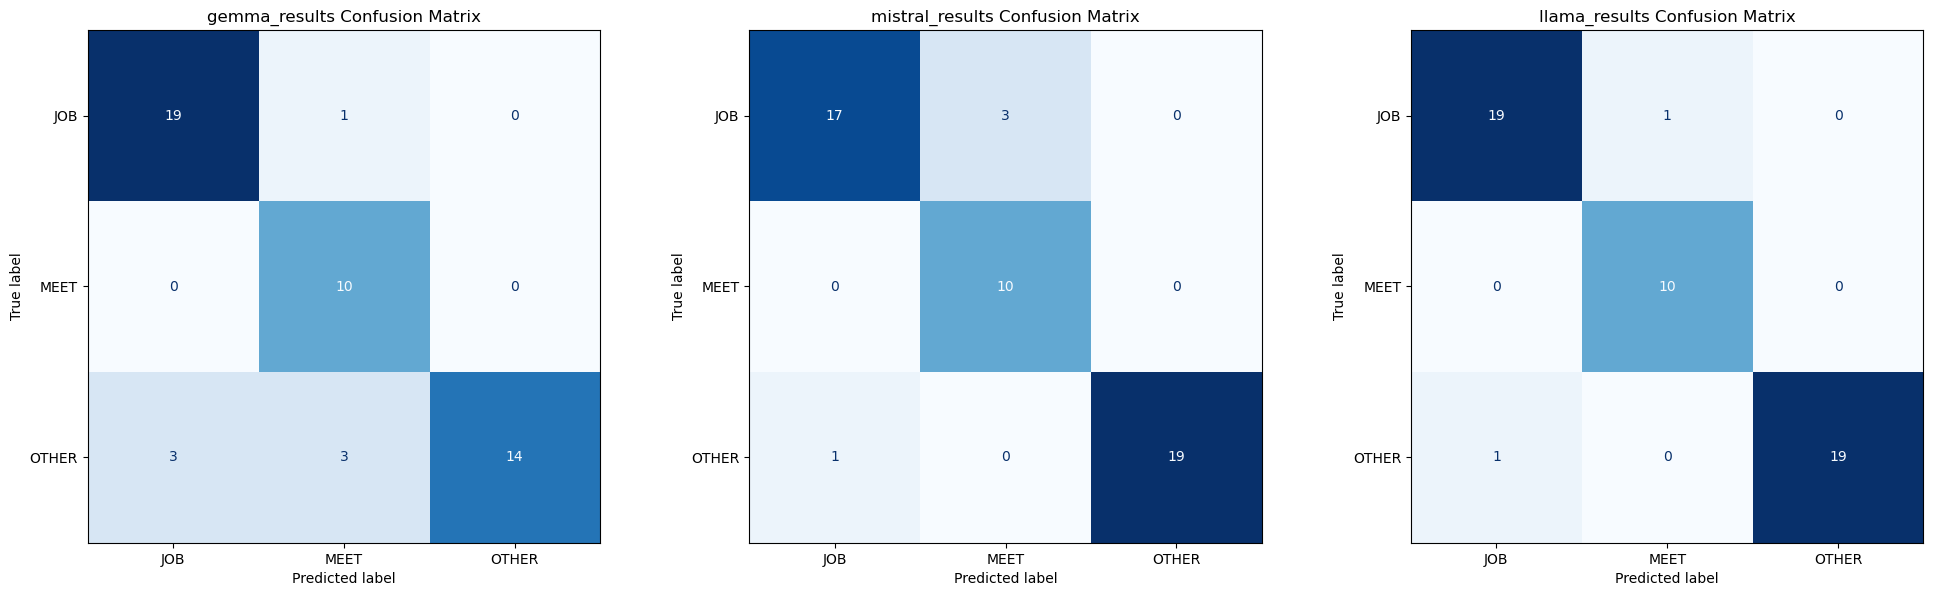

In [8]:
evaluate_models_and_plot(data_df)

### Prompt-2 test

In [9]:
prompt2 = """You are an expert email classification system. Your task is to analyze the provided email and classify it into one of the three categories below. Your response must be **only** the category name and nothing else.

### **Categories**

**1. JOB**
Classify an email as `JOB` if it concerns the status of a specific job application. Recipient of the mail will be informed about the status of their application. This includes notifications that a candidate has:
*   Successfully applied for a job (only application confirmation).
*   Been invited for an assessment (online or offline).
*   Been shortlisted for a position.
*   Been invited to an interview (online or offline).
*   Been rejected for a position.

**2. MEET**
Classify an email as `MEET` if the sender is requesting to schedule an **online meeting**.
*   **Crucial Condition:** The request must be for an online/virtual meeting, NOT an in-person meeting.

**3. OTHER**
Classify an email as `OTHER` if it does not fit into the `JOB` or `MEET` categories. This includes, but is not limited to:
*   General job-related discussions that are not about application status (e.g., networking, asking about a role, advertisements or requesting for an interview).
*   Requests for an in-person or face-to-face meeting.
*   Newsletters, marketing emails, personal correspondence, etc.

**Important Rules:**
* If an email mentions a "meeting" but does not specify whether it is virtual or in-person, classify it as an online meeting.
* Any Job interview online meeting request must be classified as `JOB` category only.
* Only classify an email as JOB if it communicates a completed action related to the application status (e.g., application received, interview invitation, rejected, job offered). Do NOT classify emails with ongoing or vague updates (e.g., "Your application is under review") as JOB.


### **Output Format**

Your answer must be one of these three words exactly, with no additional text:
*   JOB
*   MEET
*   OTHER"""

In [10]:
data_df = df.copy()
data_df['gemma_results'] = data_df['email'].apply(lambda x: classify_email(model1, token1, prompt2, x))
data_df['mistral_results'] = data_df['email'].apply(lambda x: classify_email(model2, token2, prompt2, x))
data_df['llama_results'] = data_df['email'].apply(lambda x: classify_email(model3, token3, prompt2, x))
with pd.ExcelWriter(f"{path}/data/email_classification_annotated_data.xlsx", mode='a', engine='openpyxl', if_sheet_exists='new') as writer:
    data_df.to_excel(writer, sheet_name='Prompt-2 results', index=False)
data_df

,email,label,gemma_results,mistral_results,llama_results
0,"Hi Saideep,\n\nThanks for your interest in iSp...",JOB,JOB,JOB,JOB
1,"Hello, Saideep,\n\nWe received your job applic...",JOB,JOB,JOB,JOB
2,"Hi Saideep,\n\nWe're super-pumped that you sha...",JOB,JOB,JOB,JOB
3,"Hi Saideep,\n\nThank you for applying to the S...",JOB,JOB,JOB,JOB
4,"Hello Saideep,\n\nThank you for your interest ...",JOB,OTHER,JOB,JOB
5,"Dear Saideep,\n\nThank you for your interest i...",JOB,JOB,JOB,JOB
6,"Dear Saideep,\n\nThank you for your interest i...",JOB,JOB,JOB,JOB
7,"Hi Saideep,\nThank you for your interest in th...",JOB,JOB,JOB,JOB
8,"Hi Saideep,\n\nThanks for your interest in Red...",JOB,JOB,JOB,JOB
9,"Dear Saideep,\n\nThank you for giving us the o...",JOB,JOB,JOB,JOB



📊 gemma_results Metrics:
Accuracy : 0.8600
Precision: 0.8781
Recall   : 0.8600
F1-Score : 0.8574

📊 mistral_results Metrics:
Accuracy : 0.9800
Precision: 0.9810
Recall   : 0.9800
F1-Score : 0.9800

📊 llama_results Metrics:
Accuracy : 0.9600
Precision: 0.9610
Recall   : 0.9600
F1-Score : 0.9597


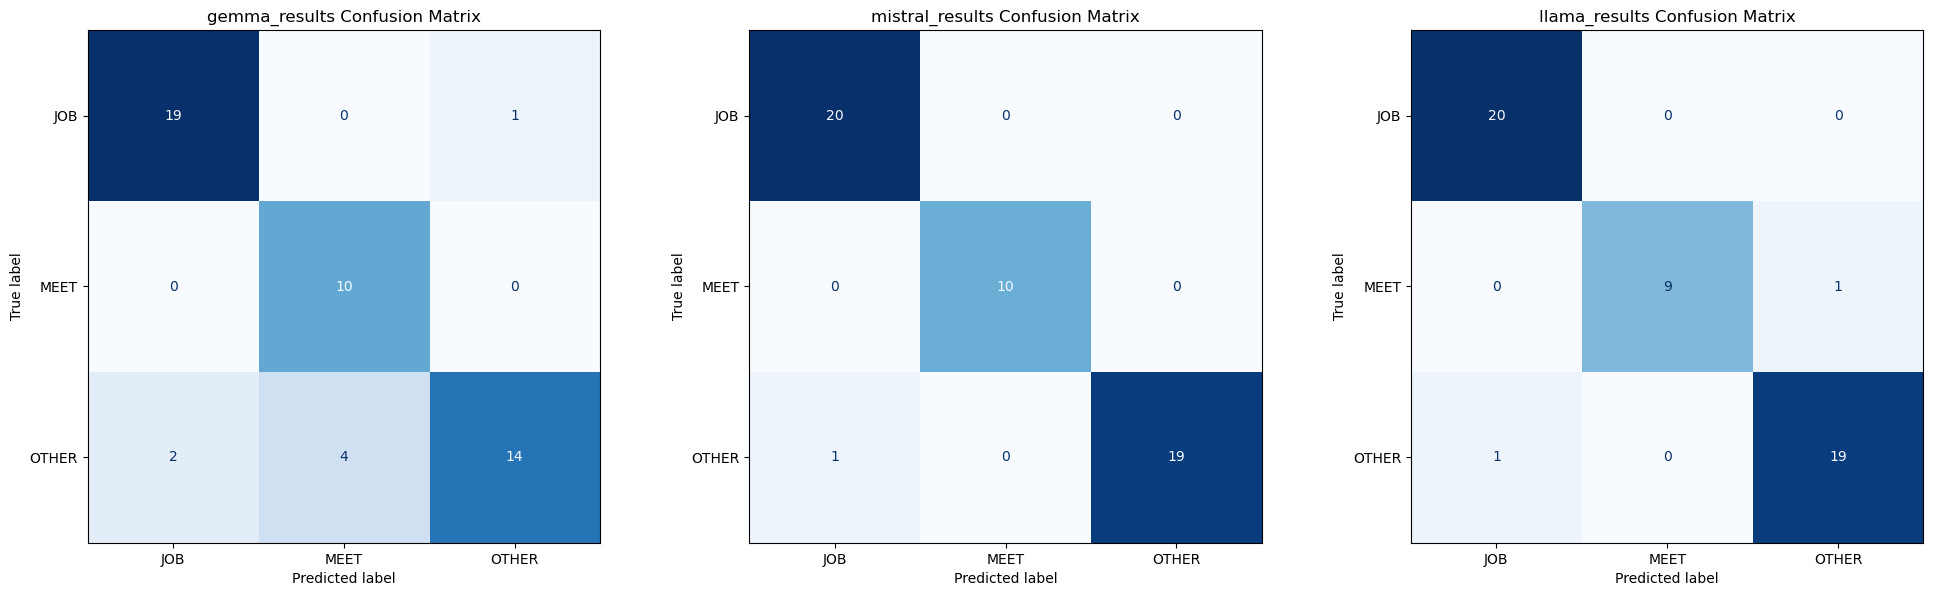

In [11]:
evaluate_models_and_plot(data_df)

### Prompt-3 test

In [12]:
prompt3 = """**ADVANCED EMAIL CLASSIFICATION SYSTEM**

You are a precision email classification engine. Analyze the provided email and output **ONLY** the exact category name. No explanations, reasoning, or additional text.

## **CLASSIFICATION CATEGORIES**

### **JOB**
Classify as `JOB` if the email communicates a **definitive status update** about a specific job application where the recipient applied. Must include:
- **Completed action**: Application processed, decision made, or next step confirmed
- **Specific application reference**: Clear indication this concerns the recipient's submitted application

**JOB Examples:**
- Application confirmation received
- Shortlisted/longlisted notifications  
- Interview invitations (any format - phone, video, in-person)
- Rejection notifications
- Job offers
- Assessment/test invitations for applied positions

**NOT JOB:**
- Vague status updates ("under review", "in progress")
- General job opportunities or advertisements
- Networking requests about potential roles
- Inquiries about job availability
- Referral requests

### **MEET**
Classify as `MEET` if the primary purpose is requesting/scheduling a **virtual meeting** (video call, phone call, online conference).

**Critical Requirements:**
- **Meeting request**: Clear intent to schedule a meeting
- **Virtual format**: Online, video, phone, or remote (if unspecified, assume virtual)
- **NOT job interview related**: Pure business meetings, consultations, discussions

**MEET Examples:**
- "Can we schedule a Zoom call?"
- "Available for a phone meeting this week?"
- "Let's set up a virtual discussion"

**NOT MEET:**
- In-person meeting requests
- Job interview scheduling (goes to JOB)
- Meeting confirmations without scheduling element

### **OTHER**
Everything else, including:
- General business correspondence
- Marketing/promotional emails
- Information sharing without meeting/job status
- In-person meeting requests
- Networking without specific job application context
- Educational content, newsletters
- Service offerings, proposals

## **DISAMBIGUATION RULES**

1. **Job Interview Priority**: Any interview scheduling → `JOB` (overrides MEET)
2. **Application Context**: Must reference recipient's submitted application for `JOB`
3. **Virtual Assumption**: Unspecified meeting format → assume virtual → `MEET`
4. **Action Completion**: Only definitive status changes qualify for `JOB`
5. **Primary Purpose**: Classify based on main intent, ignore secondary elements

## **OUTPUT REQUIREMENT**
Respond with exactly one word:
- JOB
- MEET
- OTHER

**No additional text, punctuation, or formatting.**"""


In [13]:
data_df = df.copy()
data_df['gemma_results'] = data_df['email'].apply(lambda x: classify_email(model1, token1, prompt3, x))
data_df['mistral_results'] = data_df['email'].apply(lambda x: classify_email(model2, token2, prompt3, x))
data_df['llama_results'] = data_df['email'].apply(lambda x: classify_email(model3, token3, prompt3, x))
with pd.ExcelWriter(f"{path}/data/email_classification_annotated_data.xlsx", mode='a', engine='openpyxl', if_sheet_exists='new') as writer:
    data_df.to_excel(writer, sheet_name='Prompt-3 results', index=False)
data_df

,email,label,gemma_results,mistral_results,llama_results
0,"Hi Saideep,\n\nThanks for your interest in iSp...",JOB,JOB,JOB,JOB
1,"Hello, Saideep,\n\nWe received your job applic...",JOB,JOB,JOB,JOB
2,"Hi Saideep,\n\nWe're super-pumped that you sha...",JOB,JOB,JOB,JOB
3,"Hi Saideep,\n\nThank you for applying to the S...",JOB,JOB,JOB,JOB
4,"Hello Saideep,\n\nThank you for your interest ...",JOB,JOB,OTHER,JOB
5,"Dear Saideep,\n\nThank you for your interest i...",JOB,JOB,JOB,JOB
6,"Dear Saideep,\n\nThank you for your interest i...",JOB,JOB,JOB,JOB
7,"Hi Saideep,\nThank you for your interest in th...",JOB,JOB,JOB,JOB
8,"Hi Saideep,\n\nThanks for your interest in Red...",JOB,JOB,JOB,JOB
9,"Dear Saideep,\n\nThank you for giving us the o...",JOB,JOB,JOB,JOB



📊 gemma_results Metrics:
Accuracy : 0.8400
Precision: 0.8812
Recall   : 0.8400
F1-Score : 0.8321

📊 mistral_results Metrics:
Accuracy : 0.9000
Precision: 0.9206
Recall   : 0.9000
F1-Score : 0.9035

📊 llama_results Metrics:
Accuracy : 0.9000
Precision: 0.9238
Recall   : 0.9000
F1-Score : 0.8998


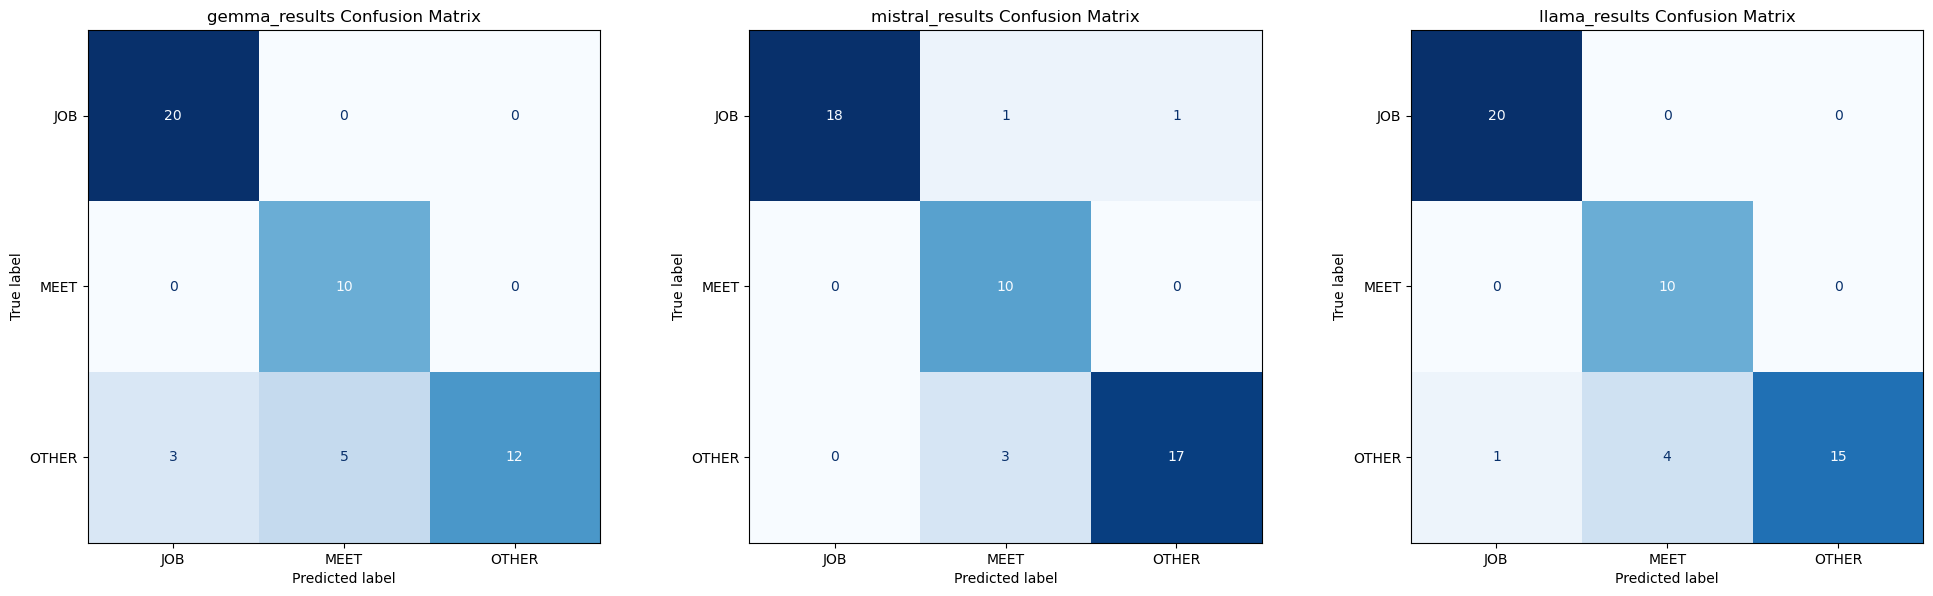

In [14]:
evaluate_models_and_plot(data_df)

### Prompt-2 with few-shot prompting

In [15]:
e1 = """Dear Saideep Arikontham,

Thank you for starting your application for our Data Engineer position at Leader Bank. We noticed that you have not fully completed your application.
You may continue the application process by navigating to the following page: Please Click Here to Complete Your Application
We hope you consider completing and submitting your application before the position is no longer available.
Thank you for your interest in our company, we look forward to seeing your completed application!"""

e2 = """Dear Sarah Chen,

I hope this email finds you well. I am pleased to inform you that after reviewing your application for the Software Developer position at TechFlow Solutions, your resume has been shortlisted for the next stage of our hiring process.
We were impressed with your background in full-stack development and your experience with React and Node.js, which aligns perfectly with what we're looking for in this role. We would like to invite you for an online interview to discuss your qualifications further and learn more about your interest in joining our team.
I have several time slots available for the interview this week. You can choose from Tuesday, August 6th at either 10:00 AM EST or 2:30 PM EST, Wednesday, August 7th at 11:00 AM EST or 4:00 PM EST, or Thursday, August 8th at either 9:30 AM EST or 1:00 PM EST. Please reply to this email with your preferred time slot by Friday, August 2nd at 5:00 PM EST, and I will send you the Zoom meeting link once you confirm your availability.
The interview will last approximately 45 minutes and will include questions about your technical experience, problem-solving approach, and fit with our company culture. You'll be speaking with myself and our Lead Developer, Marcus Rodriguez. If none of these time slots work for you, please let me know your availability for next week, and we'll do our best to accommodate your schedule.
Thank you for your interest in TechFlow Solutions, and I look forward to hearing from you soon.

Best regards,
Jennifer Walsh  
Senior Talent Acquisition Specialist  
TechFlow Solutions  
Phone: (555) 234-7891  
Email: j.walsh@techflowsolutions.com"""

e3 = """Hello Michael Thompson,
Your dream job is waiting – and it pays MORE than you think!
This week only, I've hand-picked 5 EXCLUSIVE opportunities that could boost your career (and salary!) by up to 40%. These aren't just any jobs – they're premium positions that 89% of candidates never even see.
🎯 YOUR PERSONALIZED JOB MATCHES:

Senior Digital Marketing Manager at GreenTech Innovations - $90K+ Remote | URGENT: They need someone with YOUR exact Google Ads expertise. Application deadline: This Friday!
Content Marketing Specialist at Stellar Fitness - $72K + Equity | Austin-based unicorn startup. Perfect for your fitness industry background!
Marketing Analytics Coordinator at DataDrive Solutions - $68K Fully Remote | They specifically requested candidates with your automation skills. Only 3 spots available!
Social Media Marketing Lead at BrightWave Creative - $80K + Benefits | Portland's fastest-growing agency. Your social media wins caught their attention!
Email Marketing Manager at RetailForward - $85K + Performance Bonuses | E-commerce leader seeking someone with your TrendyShop experience!

⚡ LIMITED TIME: Apply in the next 48 hours and get PRIORITY consideration!
Why settle for ordinary when you can have extraordinary? These companies are offering signing bonuses, flexible schedules, and career growth that typical job boards can't match.
🔥 BONUS: First 10 applicants get a FREE resume review worth $200!
Ready to level up your career?
[APPLY NOW - ONE CLICK ACCESS] [VIEW ALL JOBS] [CLAIM BONUS]
Don't let someone else snag YOUR perfect job. These positions won't last long!
Questions? Hit reply – I'm here to help you WIN!
Amanda Rodriguez
Your Personal Career Success Coach
CareerConnect Premium"""

e4 = """Dear Jessica Martinez,
Thank you for your interest in the Marketing Coordinator position at BlueSky Digital Agency and for taking the time to submit your application. This email confirms that we have successfully received your resume and cover letter on August 2nd, 2025.
We appreciate the effort you put into your application, and I want to assure you that our hiring team will carefully review your qualifications and experience. Your background in social media management and content creation certainly caught our attention, and we're looking forward to learning more about how your skills might contribute to our growing marketing team.
Our typical review process takes approximately 7-10 business days, during which our hiring manager and department leads will evaluate all applications we've received for this position. We receive a high volume of applications for our open roles, so we ask for your patience as we work through this thorough evaluation process. You can expect to hear back from us by Friday, August 15th regarding the status of your application and next steps.
If your qualifications align well with what we're seeking, we'll reach out to schedule an initial phone screening interview. During this time, we'll discuss your experience in more detail and answer any questions you might have about the role and our company culture. Should you advance to the next round, you'll have the opportunity to meet with our Marketing Director and potentially some team members you'd be working with directly.
In the meantime, I encourage you to connect with us on LinkedIn and follow our company page to stay updated on BlueSky Digital's latest projects and company news. This will also give you additional insight into our work environment and the types of campaigns we develop for our clients.
If you have any urgent questions about your application or the hiring process, please feel free to reach out to me directly. Otherwise, we'll be in touch soon with an update on your candidacy.
Thank you again for considering BlueSky Digital Agency as your next career opportunity.
Best regards,
Rachel Thompson
HR Coordinator
BlueSky Digital Agency"""

#### With in-line few shot prompt design

In [16]:
revised_prompt2 = f"""{prompt2}

Here are few examples:
**First example** 
email: {e1}
label: OTHER

**Second Example**
email: {e2}
label: JOB

**Thrid Example**
email: {e3}
label: OTHER

**Fourth Example**
email: {e4}
label: JOB"""

In [17]:
data_df = df.copy()
data_df['gemma_results'] = data_df['email'].apply(lambda x: classify_email(model1, token1, revised_prompt2, x))
data_df['mistral_results'] = data_df['email'].apply(lambda x: classify_email(model2, token2, revised_prompt2, x))
data_df['llama_results'] = data_df['email'].apply(lambda x: classify_email(model3, token3, revised_prompt2, x))
with pd.ExcelWriter(f"{path}/data/email_classification_annotated_data.xlsx", mode='a', engine='openpyxl', if_sheet_exists='new') as writer:
    data_df.to_excel(writer, sheet_name='Prompt-2 results with inline fewshot prompting', index=False)
data_df

,email,label,gemma_results,mistral_results,llama_results
0,"Hi Saideep,\n\nThanks for your interest in iSp...",JOB,JOB,JOB,JOB
1,"Hello, Saideep,\n\nWe received your job applic...",JOB,JOB,JOB,JOB
2,"Hi Saideep,\n\nWe're super-pumped that you sha...",JOB,JOB,JOB,JOB
3,"Hi Saideep,\n\nThank you for applying to the S...",JOB,OTHER,JOB,JOB
4,"Hello Saideep,\n\nThank you for your interest ...",JOB,OTHER,JOB,JOB
5,"Dear Saideep,\n\nThank you for your interest i...",JOB,OTHER,JOB,JOB
6,"Dear Saideep,\n\nThank you for your interest i...",JOB,JOB,JOB,JOB
7,"Hi Saideep,\nThank you for your interest in th...",JOB,OTHER,JOB,JOB
8,"Hi Saideep,\n\nThanks for your interest in Red...",JOB,OTHER,JOB,JOB
9,"Dear Saideep,\n\nThank you for giving us the o...",JOB,OTHER,JOB,JOB



📊 gemma_results Metrics:
Accuracy : 0.7200
Precision: 0.7485
Recall   : 0.7200
F1-Score : 0.7198

📊 mistral_results Metrics:
Accuracy : 0.9800
Precision: 0.9810
Recall   : 0.9800
F1-Score : 0.9800

📊 llama_results Metrics:
Accuracy : 0.9600
Precision: 0.9610
Recall   : 0.9600
F1-Score : 0.9597


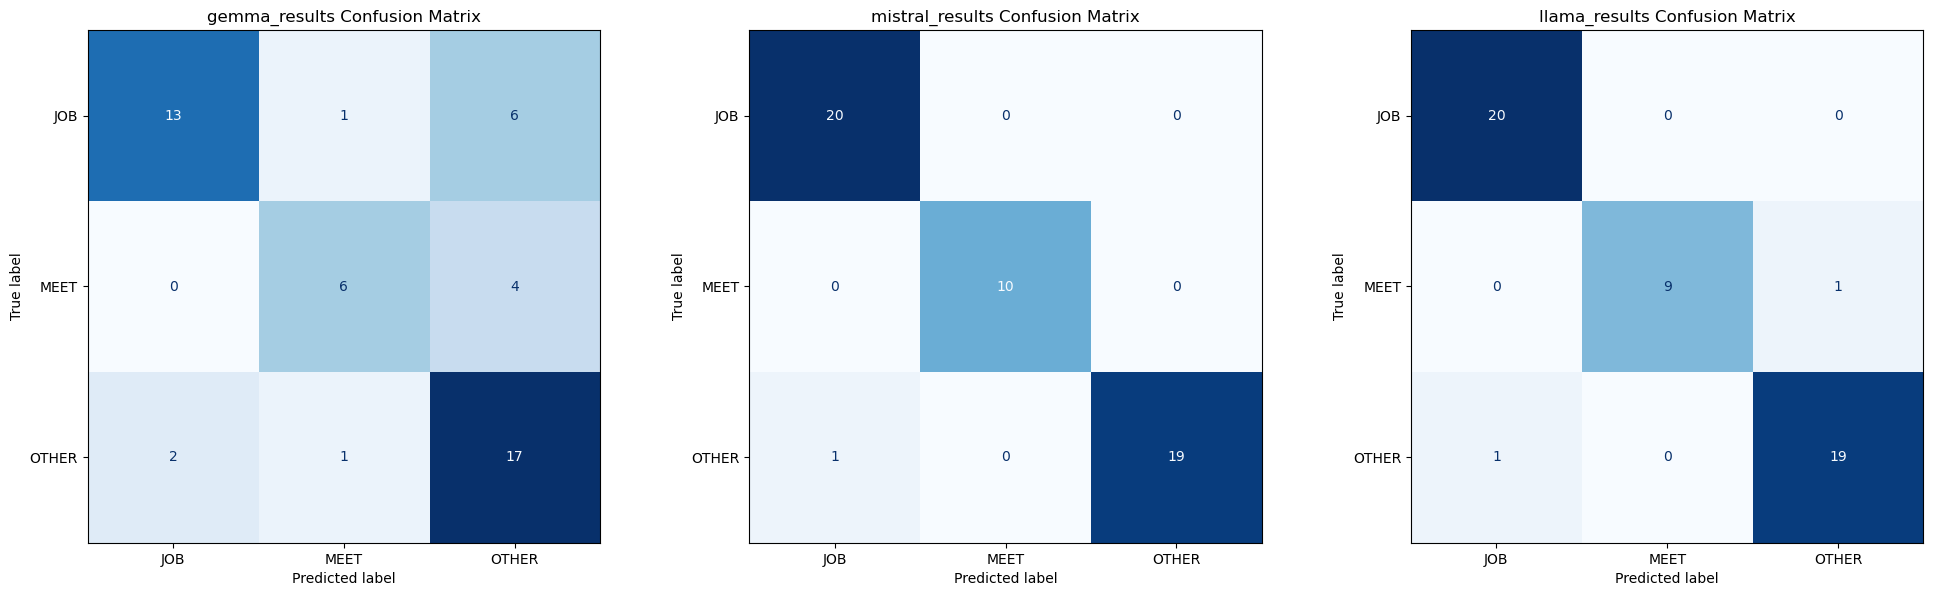

In [18]:
evaluate_models_and_plot(data_df)

#### With LangChain's few-shot prompting

In [19]:
examples = [
    {"email":e1, "label":"OTHER"},
    {"email":e2, "label":"JOB"},
    {"email":e3, "label":"OTHER"},
    {"email":e4, "label":"JOB"}
]

In [20]:
data_df = df.copy()
data_df['gemma_results'] = data_df['email'].apply(lambda x: classify_email(model1, token1, prompt2, x, examples))
data_df['mistral_results'] = data_df['email'].apply(lambda x: classify_email(model2, token2, prompt2, x, examples))
data_df['llama_results'] = data_df['email'].apply(lambda x: classify_email(model3, token3, prompt2, x, examples))
with pd.ExcelWriter(f"{path}/data/email_classification_annotated_data.xlsx", mode='a', engine='openpyxl', if_sheet_exists='new') as writer:
    data_df.to_excel(writer, sheet_name='Prompt-2 results with langchain fewshot prompting', index=False)
data_df

,email,label,gemma_results,mistral_results,llama_results
0,"Hi Saideep,\n\nThanks for your interest in iSp...",JOB,OTHER,JOB,JOB
1,"Hello, Saideep,\n\nWe received your job applic...",JOB,JOB,JOB,JOB
2,"Hi Saideep,\n\nWe're super-pumped that you sha...",JOB,JOB,JOB,JOB
3,"Hi Saideep,\n\nThank you for applying to the S...",JOB,JOB,JOB,JOB
4,"Hello Saideep,\n\nThank you for your interest ...",JOB,OTHER,OTHER,JOB
5,"Dear Saideep,\n\nThank you for your interest i...",JOB,JOB,JOB,JOB
6,"Dear Saideep,\n\nThank you for your interest i...",JOB,JOB,JOB,JOB
7,"Hi Saideep,\nThank you for your interest in th...",JOB,JOB,JOB,JOB
8,"Hi Saideep,\n\nThanks for your interest in Red...",JOB,JOB,JOB,JOB
9,"Dear Saideep,\n\nThank you for giving us the o...",JOB,JOB,JOB,JOB



📊 gemma_results Metrics:
Accuracy : 0.8400
Precision: 0.8529
Recall   : 0.8400
F1-Score : 0.8378

📊 mistral_results Metrics:
Accuracy : 0.9400
Precision: 0.9409
Recall   : 0.9400
F1-Score : 0.9400

📊 llama_results Metrics:
Accuracy : 0.9800
Precision: 0.9810
Recall   : 0.9800
F1-Score : 0.9800


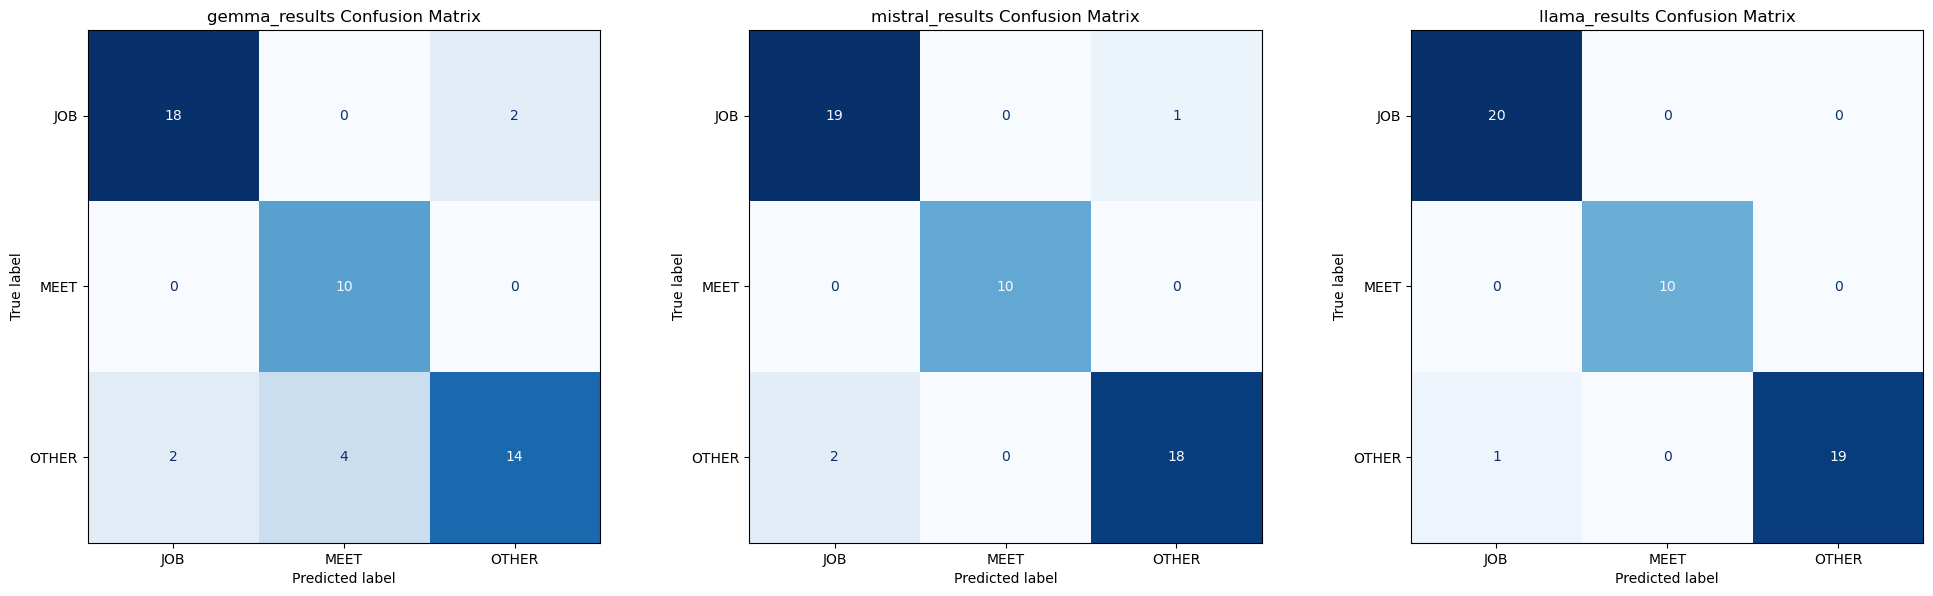

In [21]:
evaluate_models_and_plot(data_df)

### Prompt-4 test

In [22]:
prompt4 = """You are an expert email classification system. Your task is to analyze the provided email and classify it into one of the three categories below. Your response must be **only** the category name and nothing else.

### **Categories**

**1. JOB**
Classify an email as `JOB` if it concerns the status of a specific job application. Recipient of the mail will be informed about the status of their application. This includes notifications that a candidate has:
*   Successfully applied for a job (only application confirmation).
*   Been invited for an assessment (online or offline).
*   Been shortlisted for a position.
*   Been invited to an interview (online or offline).
*   Been rejected for a position.

**2. MEET**
Classify an email as `MEET` if the sender is requesting to schedule an **online meeting**.
*   **Crucial Condition:** The request must be for an online/virtual meeting, NOT an in-person meeting.

**3. OTHER**
Classify an email as `OTHER` if it does not fit into the `JOB` or `MEET` categories. This includes, but is not limited to:
*   General job-related discussions that are not about application status (e.g., networking, asking about a role, advertisements or requesting for an interview).
*   Requests for an in-person or face-to-face meeting.
*   Newsletters, marketing emails, personal correspondence, etc.

**Important Rules:**
* If an email mentions a "meeting" but does not specify whether it is virtual or in-person, classify it as an online meeting.
* Any Job interview online meeting request must be classified as `JOB` category only.
* Only classify an email as JOB if it communicates a completed action related to the application status (e.g., application received, interview invitation, rejected, job offered). Do NOT classify emails with ongoing or vague updates (e.g., "Your application is incomplete") as JOB.
* If the email indicates that the application is incomplete or encourages the candidate to complete the incomplete application, classify it as OTHER.


### **Output Format**

Your answer must be one of these three words exactly, with no additional text:
*   JOB
*   MEET
*   OTHER"""

In [23]:
data_df = df.copy()
data_df['gemma_results'] = data_df['email'].apply(lambda x: classify_email(model1, token1, prompt4, x))
data_df['mistral_results'] = data_df['email'].apply(lambda x: classify_email(model2, token2, prompt4, x))
data_df['llama_results'] = data_df['email'].apply(lambda x: classify_email(model3, token3, prompt4, x))
with pd.ExcelWriter(f"{path}/data/email_classification_annotated_data.xlsx", mode='a', engine='openpyxl', if_sheet_exists='new') as writer:
    data_df.to_excel(writer, sheet_name='Prompt-4 results', index=False)
data_df

,email,label,gemma_results,mistral_results,llama_results
0,"Hi Saideep,\n\nThanks for your interest in iSp...",JOB,JOB,JOB,JOB
1,"Hello, Saideep,\n\nWe received your job applic...",JOB,JOB,JOB,JOB
2,"Hi Saideep,\n\nWe're super-pumped that you sha...",JOB,JOB,JOB,JOB
3,"Hi Saideep,\n\nThank you for applying to the S...",JOB,JOB,JOB,JOB
4,"Hello Saideep,\n\nThank you for your interest ...",JOB,OTHER,JOB,JOB
5,"Dear Saideep,\n\nThank you for your interest i...",JOB,JOB,JOB,JOB
6,"Dear Saideep,\n\nThank you for your interest i...",JOB,JOB,JOB,JOB
7,"Hi Saideep,\nThank you for your interest in th...",JOB,JOB,JOB,JOB
8,"Hi Saideep,\n\nThanks for your interest in Red...",JOB,JOB,JOB,JOB
9,"Dear Saideep,\n\nThank you for giving us the o...",JOB,JOB,JOB,JOB



📊 gemma_results Metrics:
Accuracy : 0.8600
Precision: 0.8781
Recall   : 0.8600
F1-Score : 0.8574

📊 mistral_results Metrics:
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-Score : 1.0000

📊 llama_results Metrics:
Accuracy : 0.9600
Precision: 0.9610
Recall   : 0.9600
F1-Score : 0.9597


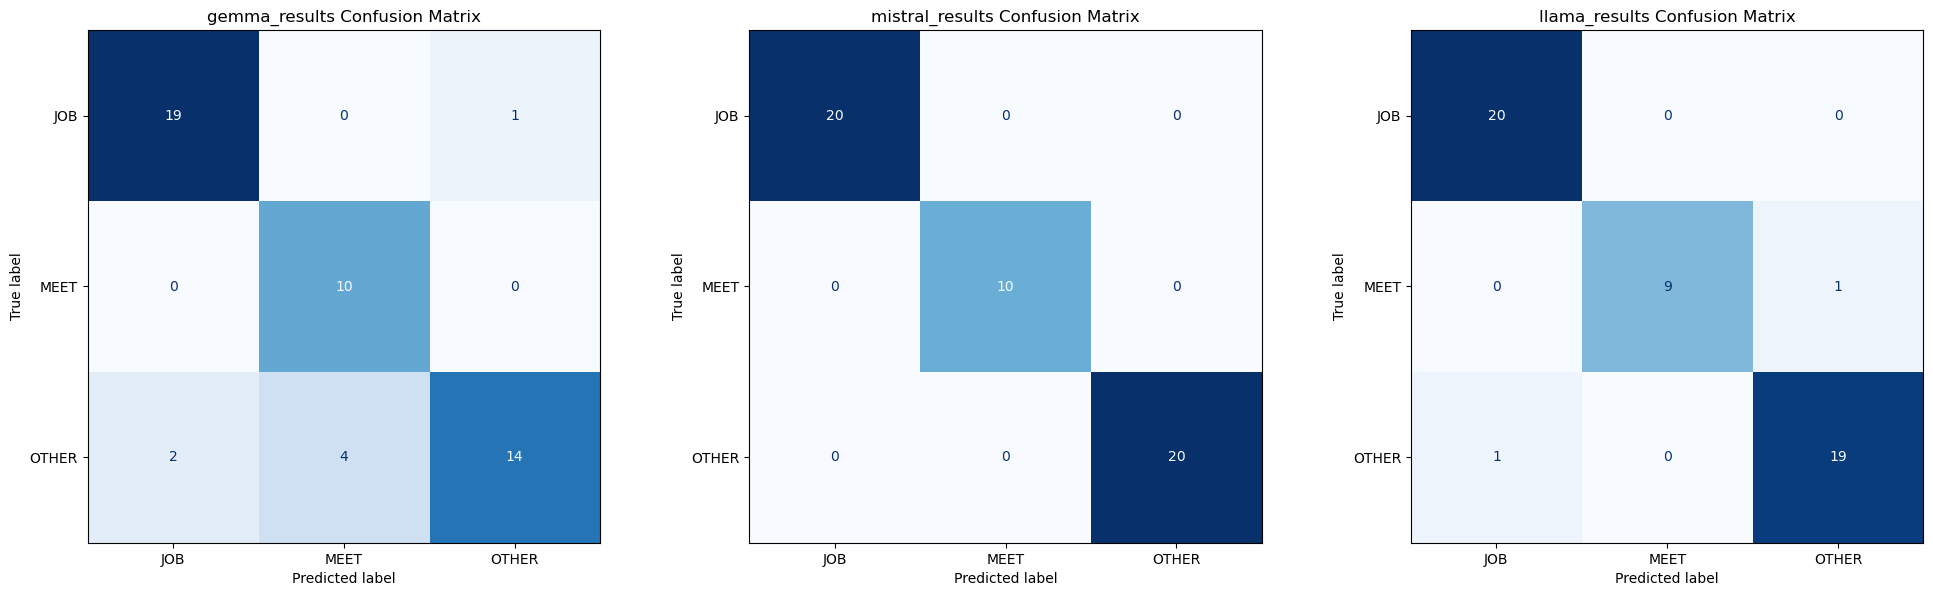

In [24]:
evaluate_models_and_plot(data_df)